In [20]:
pip install seaborn


   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ----------------- ---------------------- 5.0/11.3 MB 25.1 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.3 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 20.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import os
import seaborn as sns
import cv2
import torch
import timm
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, models, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch.utils.data import DataLoader, Dataset,Subset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import random

In [6]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
dir_data=r"C:\Users\Minoo\Desktop\Covid19-dataset"

In [8]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = r'C:\Users\Minoo\Desktop\Covid19-dataset\train'
TESTING_DIR = r'C:\Users\Minoo\Desktop\Covid19-dataset\test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.


Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


In [9]:
import math

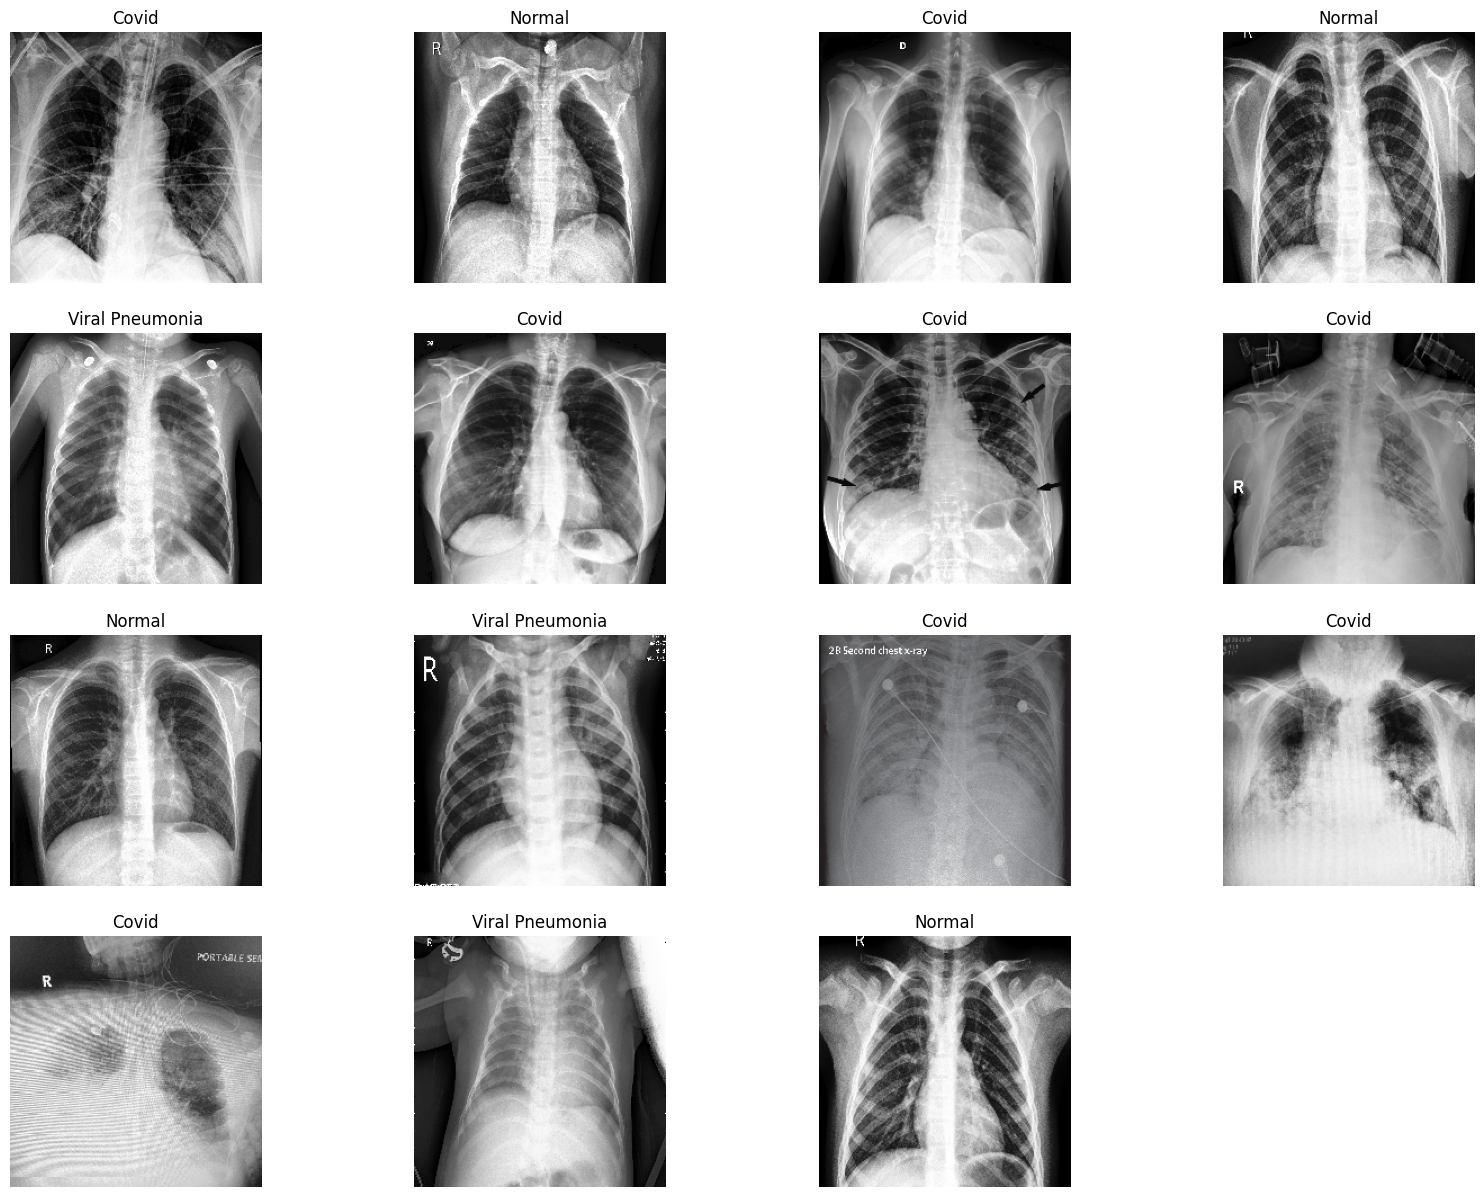

In [10]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

In [11]:
# Option A: Import specific preprocessing layers directly
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

# Option B: Import all of keras.layers
from tensorflow.keras import layers

# Option C: Use tf.keras directly
import tensorflow as tf

In [12]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [13]:


tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,579 (56.89 MB)

 Trainable params: 197,891 (773.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

# Create model directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Now your callbacks will work
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model/vgg16_best.h5', 
    monitor='val_accuracy',  # Changed from 'acc' to 'val_accuracy'
    verbose=1, 
    mode='max',
    save_best_only=True
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    mode="min",
    restore_best_weights=True, 
    patience=5
)

callbacks_list = [checkpoint, early]

print("✅ Callbacks created successfully!")

✅ Callbacks created successfully!


In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

c:\Users\Minoo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - acc: 0.3742 - loss: 1.2242
Epoch 1: acc improved from -inf to 0.36653, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 13s/step - acc: 0.3727 - loss: 1.2269 - val_acc: 0.3939 - val_loss: 1.0347
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.4087 - loss: 1.1315
Epoch 2: acc improved from 0.36653 to 0.43426, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - acc: 0.4138 - loss: 1.1232 - val_acc: 0.5152 - val_loss: 1.0072
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - acc: 0.5402 - loss: 0.9736
Epoch 3: acc improved from 0.43426 to 0.50199, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - acc: 0.5326 - loss: 0.9816 - val_acc: 0.6970 - val_loss: 0.9169
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - acc: 0.5228 - loss: 0.9338
Epoch 4: acc improved from 0.50199 to 0.54183, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 12s/step - acc: 0.5266 - loss: 0.9336 - val_acc: 0.7121 - val_loss: 0.8616
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - acc: 0.5336 - loss: 0.9279
Epoch 5: acc improved from 0.54183 to 0.54582, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 12s/step - acc: 0.5360 - loss: 0.9220 - val_acc: 0.8182 - val_loss: 0.7757
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - acc: 0.6710 - loss: 0.7839
Epoch 6: acc improved from 0.54582 to 0.68127, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - acc: 0.6730 - loss: 0.7843 - val_acc: 0.7727 - val_loss: 0.6933
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - acc: 0.7036 - loss: 0.7278
Epoch 7: acc improved from 0.68127 to 0.69721, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - acc: 0.7023 - loss: 0.7279 - val_acc: 0.8333 - val_loss: 0.6142
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.7402 - loss: 0.7051
Epoch 8: acc improved from 0.69721 to 0.72112, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 13s/step - acc: 0.7364 - loss: 0.7024 - val_acc: 0.9091 - val_loss: 0.5565
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.7683 - loss: 0.6373
Epoch 9: acc improved from 0.72112 to 0.74502, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.7636 - loss: 0.6411 - val_acc: 0.7879 - val_loss: 0.5114
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8104 - loss: 0.5752
Epoch 10: acc improved from 0.74502 to 0.76494, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step - acc: 0.8013 - loss: 0.5831 - val_acc: 0.8485 - val_loss: 0.4669
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.7982 - loss: 0.5491
Epoch 11: acc improved from 0.76494 to 0.79681, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 13s/step - acc: 0.7979 - loss: 0.5490 - val_acc: 0.8939 - val_loss: 0.4317
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8229 - loss: 0.5101
Epoch 12: acc improved from 0.79681 to 0.80478, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.8193 - loss: 0.5152 - val_acc: 0.9242 - val_loss: 0.4019
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.7760 - loss: 0.5078
Epoch 13: acc did not improve from 0.80478
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.7786 - loss: 0.4999 - val_acc: 0.8333 - val_loss: 0.3921
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8205 - loss: 0.4689
Epoch 14: acc improved from 0.80478 to 0.83665, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 13s/step - acc: 0.8237 - loss: 0.4681 - val_acc: 0.9242 - val_loss: 0.3572
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8665 - loss: 0.4176
Epoch 15: acc improved from 0.83665 to 0.85657, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 12s/step - acc: 0.8645 - loss: 0.4204 - val_acc: 0.9091 - val_loss: 0.3353
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9139 - loss: 0.3469
Epoch 16: acc improved from 0.85657 to 0.90040, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.9112 - loss: 0.3517 - val_acc: 0.8333 - val_loss: 0.3365
Epoch 17/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8591 - loss: 0.3974 
Epoch 17: acc did not improve from 0.90040
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 13s/step - acc: 0.8626 - loss: 0.3944 - val_acc: 0.8333 - val_loss: 0.3237
Epoch 18/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8656 - loss: 0.3870
Epoch 18: acc did not improve from 0.90040
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.8662 - loss: 0.3864 - val_acc: 0.9091 - val_loss: 0.2944
Epoch 19/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8386 - loss: 0.3626
Epoch 19: acc did not improve from 0.90040
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - acc: 0.8454 - loss: 0.3552 - val_acc: 0.9091 - val_loss: 0.2832
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9008 - loss: 0.2895
Epoch 20: acc did not improve from 0.90040
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - acc: 0.8992 - loss: 0.2916 - val_acc: 0.9242 - val_loss: 0.2711

4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step - acc: 0.9029 - loss: 0.2806 - val_acc: 0.9242 - val_loss: 0.2621
Epoch 22/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9195 - loss: 0.2731
Epoch 22: acc improved from 0.90837 to 0.91235, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.9181 - loss: 0.2725 - val_acc: 0.9091 - val_loss: 0.2565
Epoch 23/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9398 - loss: 0.2193
Epoch 23: acc improved from 0.91235 to 0.94422, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step - acc: 0.9407 - loss: 0.2191 - val_acc: 0.8485 - val_loss: 0.2728
Epoch 24/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9198 - loss: 0.2459
Epoch 24: acc did not improve from 0.94422
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step - acc: 0.9159 - loss: 0.2501 - val_acc: 0.8939 - val_loss: 0.2347
Epoch 25/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8837 - loss: 0.2721
Epoch 25: acc did not improve from 0.94422
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.8894 - loss: 0.2668 - val_acc: 0.9242 - val_loss: 0.2257
Epoch 26/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9054 - loss: 0.2636
Epoch 26: acc did not improve from 0.94422
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step - acc: 0.9044 - loss: 0.2618 - val_acc: 0.9394 - val_loss: 0.2163
Epoch 27/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9169 - loss: 0.2161
Epoch 27: acc did not improve from 0.94422
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step - acc: 0.9160 - loss: 0.2191 - val_acc: 0.8636 - val_loss: 0.2451


4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - acc: 0.9679 - loss: 0.1730 - val_acc: 0.8939 - val_loss: 0.2071
Epoch 31/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9339 - loss: 0.2225
Epoch 31: acc did not improve from 0.95618
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.9344 - loss: 0.2185 - val_acc: 0.9091 - val_loss: 0.1975
Epoch 32/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9373 - loss: 0.1787
Epoch 32: acc did not improve from 0.95618
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.9403 - loss: 0.1760 - val_acc: 0.9545 - val_loss: 0.1755
Epoch 33/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9206 - loss: 0.1685
Epoch 33: acc did not improve from 0.95618
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step - acc: 0.9229 - loss: 0.1679 - val_acc: 0.9394 - val_loss: 0.1729
Epoch 34/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9516 - loss: 0.1703
Epoch 34: acc did not improve from 0.95618
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.9517 - loss: 0.1676 - val_acc: 0.9394 - val_loss: 0.1685


4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.9711 - loss: 0.0953 - val_acc: 0.9545 - val_loss: 0.1469
Epoch 45/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9650 - loss: 0.0974
Epoch 45: acc did not improve from 0.96813
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 13s/step - acc: 0.9648 - loss: 0.0979 - val_acc: 0.9848 - val_loss: 0.1353
Epoch 46/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9849 - loss: 0.0833
Epoch 46: acc improved from 0.96813 to 0.97610, saving model to model/vgg16_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.9831 - loss: 0.0841 - val_acc: 0.9242 - val_loss: 0.1601
Epoch 47/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9571 - loss: 0.1227
Epoch 47: acc did not improve from 0.97610
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - acc: 0.9569 - loss: 0.1229 - val_acc: 0.8788 - val_loss: 0.1978
Epoch 48/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9614 - loss: 0.1136 
Epoch 48: acc did not improve from 0.97610
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 13s/step - acc: 0.9611 - loss: 0.1128 - val_acc: 0.9545 - val_loss: 0.1358
Epoch 49/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.9699 - loss: 0.0758 
Epoch 49: acc did not improve from 0.97610
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 14s/step - acc: 0.9679 - loss: 0.0803 - val_acc: 0.9545 - val_loss: 0.1185
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - acc: 0.9640 - loss: 0.1032 
Epoch 50: acc did not improve from 0.97610
4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 14s/step - acc: 0.9649 - loss: 0.1017 - val_acc: 0.9545 - val_loss: 0.

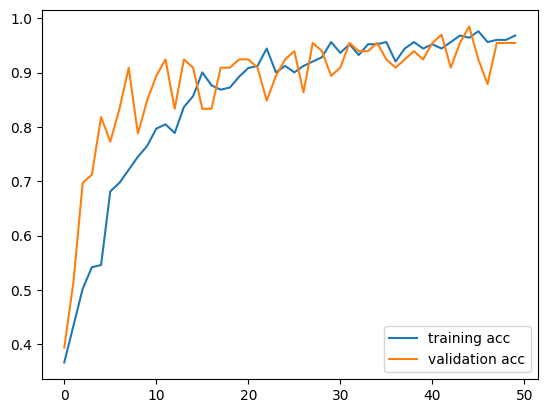

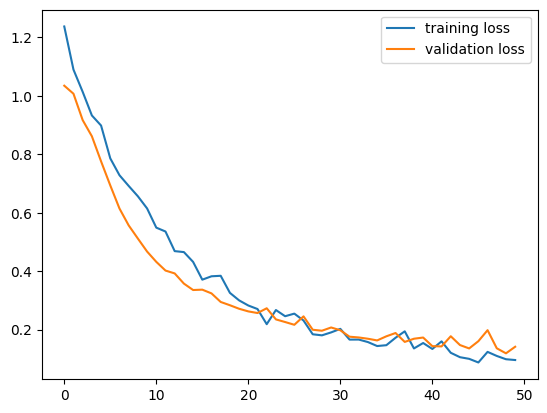

In [16]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [23]:
import pandas as pd

In [24]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - acc: 0.9753 - loss: 0.0845
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - acc: 0.9541 - loss: 0.1195


,Train,Val
Loss,0.071983,0.118544
Acc,0.976096,0.954545


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93        20
         1.0       0.95      0.90      0.92        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66



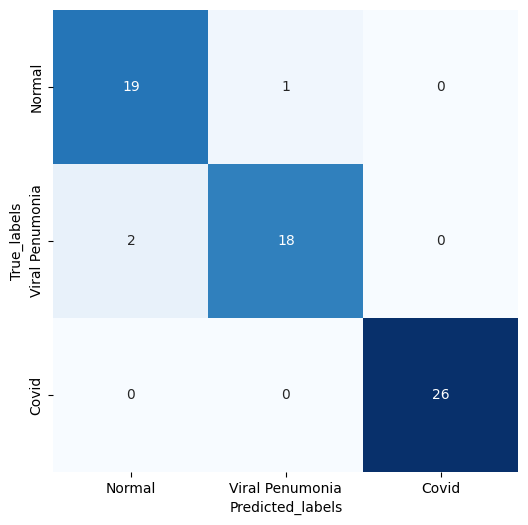

In [25]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))